In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys

sys.path.append('../')
import swotpass.satpass as satpass


In [2]:
domain = (145,160,-59,-51)
sw = satpass.NominalTrack(mission='sw') # "swi" for fast sampling phase

### Spatial selection only

##### using select_in_area() function

In [3]:
#### Science phase

swot_tracks = sw.select_in_area(domain) # Nominal swot tracks in the domain, contain few lon/lat points to plot tracks
swot_tracks  # track / lon / lat

,track,lon,lat
1873,4,153.271524,-51.101563
1874,4,153.444136,-51.444395
1875,4,153.619779,-51.786936
1876,4,153.798474,-52.129058
1877,4,153.980331,-52.470806
...,...,...,...
276553,560,158.909141,-56.538602
276554,560,159.141034,-56.874411
276555,560,159.377588,-57.209657
276556,560,159.618940,-57.544324


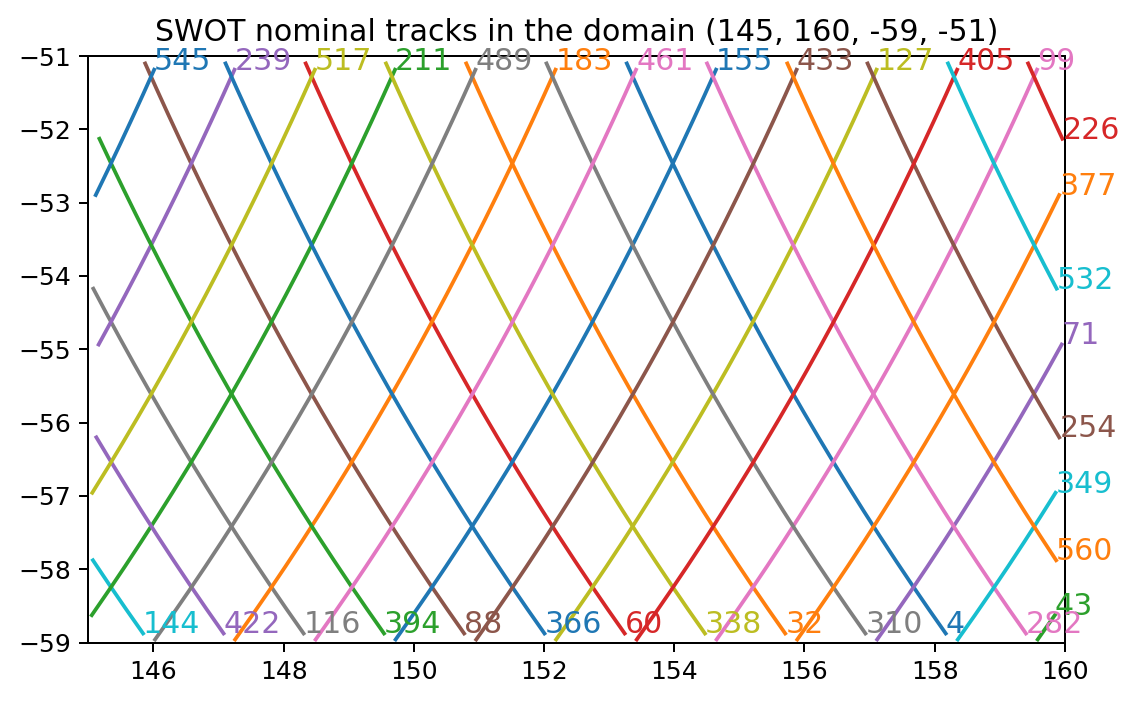

In [4]:
plt.figure(figsize = (12, 4), dpi = 180)

plt.subplot(121)
swot_tracks = sw.select_in_area(domain)

for n in np.unique(swot_tracks.track):
    
    track = swot_tracks[swot_tracks.track == n]
    im =plt.plot(track.lon, track.lat)[0]
    c = im.get_color()
    plt.text(track.lon.values[-1], track.lat.values[-1], n, c = c, fontsize = 12)

plt.title(f'SWOT nominal tracks in the domain {domain}')
plt.xlim(domain[:2])
plt.ylim(domain[2:])

plt.tight_layout()

### Spatio-temporal selection
##### sat_pass() function

In [5]:
nt = sw
date_range = [pd.Timestamp('2023-11-13'), pd.Timestamp('2023-11-17')]
swot_passes = satpass.sat_pass('sw', date_range, domain) # Actual swot passes that pass in the region during the given time interval

swot_passes

,track,direction,cycle,time
2023-11-13 14:58:00,310,des,6.0,2023-11-13 14:58:00
2023-11-14 14:59:00,338,des,6.0,2023-11-14 14:59:00
2023-11-14 23:51:00,349,asc,6.0,2023-11-14 23:51:00
2023-11-15 14:59:00,366,des,6.0,2023-11-15 14:59:00
2023-11-15 23:53:00,377,asc,6.0,2023-11-15 23:53:00
2023-11-16 15:00:00,394,des,6.0,2023-11-16 15:00:00
2023-11-16 23:53:00,405,asc,6.0,2023-11-16 23:53:00


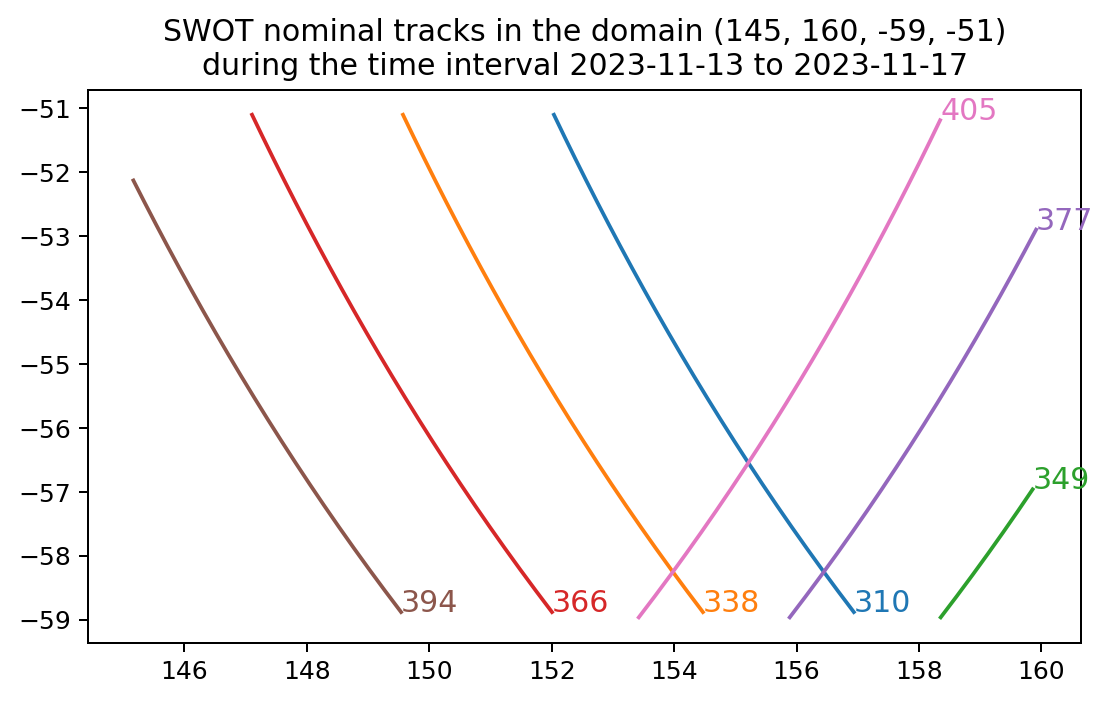

In [6]:
plt.figure(figsize = (12, 4), dpi = 180)

plt.subplot(121)
swot_tracks = sw.select_in_area(domain) # Nominal swot tracks in the domain, contain few lon/lat points to plot tracks
swot_passes = satpass.sat_pass('sw', date_range, domain) # Actual swot passes that pass in the region during the given time interval

for track in swot_passes.track:
    if track in swot_tracks.track.values:
        df = swot_tracks[swot_tracks.track == track]
        im = plt.plot(df.lon, df.lat)[0]
        c = im.get_color()
        plt.text(df.lon.values[-1], df.lat.values[-1], track, c = c, fontsize = 12)

plt.title(f'SWOT nominal tracks in the domain {domain}\nduring the time interval {date_range[0].date()} to {date_range[1].date()}')
plt.tight_layout() 